In [1]:
import pandas as pd
from utils import config
from utils.bert.data import *

from sklearn.model_selection import train_test_split

# config.xls_path = '../Train-Data/Mix6_mainCat_20/pro_review.xlsx'
# config.xls_path = '/home/eagleuser/Users/leyan/Train-Data/Mix6_mainCat_new/pro_review.xlsx'

total_df = pd.read_excel(config.xls_path)
# total_df = total_df[total_df['review_len']>=50]
# total_df = total_df[total_df['summary_len']>=5]
total_df = total_df.sort_values(by=['review_len','overlap'], ascending = False)
train_df, val_df = train_test_split(total_df, test_size=0.1, 
                                    random_state=0, shuffle=True)
vocab = Vocab()
tokenizer = vocab.tokenizer

print(len(total_df))
print(len(train_df))
print(len(val_df))

# train : 504075(90%),    test : 56009(10%) -> best 566084

vocab_file ../temp/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
{'BOS': 1, 'EOS': 2, 'PAD': 0, 'EOQ': 3, 'SEP': 102, 'CLS': 101, 'UNK': 100}
560084
504075
56009


In [2]:
def longest_common_subsequence(main_string, comparing_string):

#     main_string = main_string.split(" ")
#     comparing_string = comparing_string.split(" ")
    columns_length = len(main_string)  # Get the length of the first word or base word
    rows_length = len(comparing_string)  # Get the length of the second word or comparing word

    # MAKE A 2D LIST (MATRIX)
    dynamic_table = [[0] * (columns_length + 1) for i in range(rows_length + 1)]

    # rows_length = NUMBER OF ROWS
    # columns_length = NUMBER OF COLUMNS
    
    # FILL THE MATRIX FOLLOWING LCS ALGORITHM.
    for i in range(1, rows_length + 1):
        for j in range(1, columns_length + 1):
            if main_string[j - 1] == comparing_string[i - 1]:
                dynamic_table[i][j] = 1 + dynamic_table[i - 1][j - 1]

            else:
                dynamic_table[i][j] = max(dynamic_table[i - 1][j], dynamic_table[i][j - 1])

#     print("MATRIX ACCORDING TO LONGEST COMMON SUBSEQUENCE ALGORITHM: \n ")

    # for i in range(rows_length + 1):
    #     print(dynamic_table[i])

    #print("LENGTH OF LONGEST COMMON SUBSEQUENCE = ", dynamic_table[rows_length][columns_length])

    len_lcs = dynamic_table[rows_length][columns_length]

    i = len(comparing_string)
    j = len(main_string)

    lcs_string = str()

    # BACKTRACKING TO FIND THE LONGEST COMMON SUBSEQUENCE

    temp = True

    while temp is True:
        if dynamic_table[i][j] == 0:
            temp = False
        elif dynamic_table[i][j] == dynamic_table[i][j - 1]:
            j = j - 1

        else:
            lcs_string = main_string[j-1] + " " + lcs_string
            i = i - 1
            j = j - 1

    return lcs_string, len_lcs

In [3]:
# df.loc[i,'token_lcs'] = token_lcs
#             df.loc[i,'len_lcs'] = len_lcs
#             df.loc[i,'percent_lcs'] = percent_lcs
#             df.loc[i,'overlap_pos'] = overlap_pos
            
#             df.loc[i,'reveiw_len'] = len(rev_tokens)
#             df.loc[i,'summary_len'] = len(summary_tokens)

In [4]:
#%%
from tqdm import tqdm
from copy import deepcopy
def analay(df, mode):
    
    df['token_lcs'] = 0
    df['len_lcs'] = 0
    df['percent_lcs'] = 0
    df['overlap_pos'] = 0

    df['reveiw__len'] = 0
    df['summary_len'] = 0
#     df = df[:100]
    with tqdm(total=len(df)) as pbar:
        for i ,row in df.iterrows():       
            overlap_pos = None

            rev, summary = row['review'], row['summary']
            rev_tokens, summary_tokens = tokenizer.tokenize(rev), tokenizer.tokenize(summary)            
            token_lcs, len_lcs = longest_common_subsequence(rev_tokens, summary_tokens)
            percent_lcs = len_lcs / len(summary_tokens) * 100 # percent

            rev_sents = rev.split(" . ")
            overlap_sents = {idx: longest_common_subsequence(tokenizer.tokenize(sent), summary_tokens) for idx, sent in enumerate(rev_sents)}
            sort_overlap_sent = {k:v for k,v in sorted(overlap_sents.items(), key= lambda item: item[1], reverse=True)}
            overlap_sent_id = list(sort_overlap_sent.items())[0][0]

            if (overlap_sent_id == 0) and (percent_lcs >= 20): overlap_pos = 0 # overlap_Top 
            elif (overlap_sent_id == len(rev_tokens)-1) and (percent_lcs >= 20): overlap_pos = 1 # overlap_Final 
            elif (percent_lcs >= 20): overlap_pos = 2 # overlap_other 
            else: overlap_pos = -1 # no overlap 

            df.loc[i,'token_lcs'] = token_lcs
            df.loc[i,'len_lcs'] = len_lcs
            df.loc[i,'percent_lcs'] = percent_lcs
            df.loc[i,'overlap_pos'] = overlap_pos
            
            df.loc[i,'reveiw_len'] = len(rev_tokens)
            df.loc[i,'summary_len'] = len(summary_tokens)
            pbar.update(1)
            pbar.set_description("%s row: %s | overlap_pos_bert: %s (%2.2f)percent_bert| len_lcs_bert: %s" % (mode, i, overlap_pos, percent_lcs, len_lcs))
    return df



In [5]:
train_df.head()

,review,summary,cheat,cheat_num,review_len,summary_len,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keywords,overlap,binaryrating,vote
164361,after month read review and news finally purch...,<s> with the right lens almost as portable as ...,"{'right', 'lens', 'shoot', 'point'}",1,619,13,"deal good,pancake aspherical,deal good,pancake...","deal good,review news,pancake aspherical,lens ...",NaN,camera lens nbsp quality good read come mode l...,NaN,NaN,NaN
437736,system fail once . restore the system have dow...,<s> system fail once to restore the system hav...,"{'restore', 'fail', 'system'}",1,40,10,"system restore,trial free","software free,trial free",NaN,software,NaN,NaN,NaN
330010,love the soft feel this fleece . also the perf...,<s> love the soft feel of this fleece </s>,"{'love', 'fleece', 'feel', 'soft'}",2,43,9,"feel soft,amount perfect,day cool,lining scrat...","feel soft,day cool,lining uncomfortable",NaN,feel,NaN,NaN,NaN
326457,this the third progressive set buy for grandso...,<s> these are real club and great value do not...,"{'great', 'fool', 'club', 'number', 'real'}",1,40,17,"set progressive,club real,number fool,player e...","set progressive,club real,club real,score expe...",NaN,progressive set new,NaN,NaN,NaN
43583,div class div input type hide name value class...,<s> good little frame for the price </s>,"{'price', 'frame', 'good'}",1,135,8,"maneuver easy,brightness set,size good,website...","frame good,maneuver easy,set brightness,contra...",NaN,good look class photo person input think like,NaN,NaN,NaN


In [6]:
val_df.head()

,review,summary,cheat,cheat_num,review_len,summary_len,POS_keys,DEP_keys,Noun_adj_keys,TextRank_keywords,overlap,binaryrating,vote
361033,four and half handy star the sleek black porta...,<s> oxa mah charger is versatile quick charge ...,"{'dual', 'port', 'mah', 'oxa', 'device', 'char...",0,235,12,"star handy,plastic portable,port dual,meter di...","star handy,plastic sleek,plastic black,plastic...",NaN,charge port useful device smartphone use mah c...,NaN,NaN,NaN
341766,buy this bag august and have abuse ever since ...,<s> the zipper are sturdy too and have not hav...,"{'issue', 'zipper', 'sturdy'}",2,84,14,"bag buy,hole small,bag good","material durable,reinforce bag,pocket smaller,...",NaN,bag good,NaN,NaN,NaN
546296,this product has high quality ingredient the r...,<s> high quality ingredient that my cat love w...,"{'love', 'filler', 'high', 'cat', 'find', 'bra...",1,514,17,"quality high,filler include,food canned,food d...","quality high,food wet,food canned,food dry,foo...",NaN,food product chicken cat raw quality better pr...,NaN,NaN,NaN
302063,this does not fit inch tire . the longest the ...,<s> everything now work perfect and the sparet...,"{'rack', 'work', 'perfect', 'fit', 'modificati...",2,50,15,bracket middle,"bracket middle,shortest bracket",NaN,fit inch,NaN,NaN,NaN
123757,alert are false . alert are late . subject mis...,<s> subject miss quality for the camera and se...,"{'setup', 'camera', 'alert', 'easy', 'ton', 's...",3,80,20,"alert false,subject lose,capture wait",alert false,NaN,false ton alert subject,NaN,NaN,NaN


In [35]:
import os

if os.path.exists('Analay/bert_train_df.xlsx'):
    p_train_df = pd.read_excel('Analay/bert_train_df.xlsx')
    p_val_df = pd.read_excel('Analay/bert_val_df.xlsx')
else:    
    p_train_df = analay(deepcopy(train_df), 'train')
    p_train_df.to_excel('Analay/bert_train_df.xlsx', encoding='utf8')

    p_val_df = analay(deepcopy(val_df), 'test')
    p_val_df.to_excel('Analay/bert_val_df.xlsx', encoding='utf8')

Index(['review', 'summary', 'cheat', 'cheat_num', 'review_len', 'summary_len',
       'POS_keys', 'DEP_keys', 'Noun_adj_keys', 'TextRank_keywords', 'overlap',
       'binaryrating', 'vote', 'token_lcs', 'len_lcs', 'percent_lcs',
       'overlap_pos', 'reveiw__len', 'reveiw_len'],
      dtype='object')


In [8]:
p_train_df.describe()

,cheat_num,review_len,summary_len,Noun_adj_keys,overlap,binaryrating,vote,len_lcs,percent_lcs,overlap_pos,reveiw__len,reveiw_len
count,504075.000000,504075.000000,504075.000000,0.0,0.0,0.0,0.0,504075.000000,504075.000000,504075.000000,504075.0,504075.000000
mean,1.201198,133.084476,18.156072,NaN,NaN,NaN,NaN,7.459467,40.193632,1.310767,0.0,141.532282
std,0.895447,131.237904,3.933269,NaN,NaN,NaN,NaN,3.478934,13.125338,1.026670,0.0,141.279015
min,0.000000,20.000000,10.000000,NaN,NaN,NaN,NaN,1.000000,3.333333,-1.000000,0.0,20.000000
25%,1.000000,51.000000,15.000000,NaN,NaN,NaN,NaN,5.000000,29.411765,0.000000,0.0,53.000000
50%,1.000000,89.000000,17.000000,NaN,NaN,NaN,NaN,7.000000,40.000000,2.000000,0.0,94.000000
75%,2.000000,163.000000,20.000000,NaN,NaN,NaN,NaN,9.000000,50.000000,2.000000,0.0,173.000000
max,7.000000,1000.000000,75.000000,NaN,NaN,NaN,NaN,57.000000,82.758621,2.000000,0.0,5413.000000


reveiw_len < 30 : 32157
reveiw_len > 700 : 6094
count    504075.000000
mean        141.532282
std         141.279015
min          20.000000
25%          53.000000
50%          94.000000
75%         173.000000
max        5413.000000
Name: reveiw_len, dtype: float64


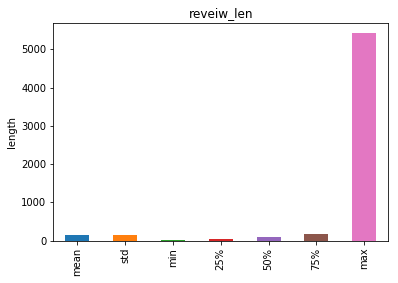

In [19]:
import matplotlib.pyplot as plt
print('reveiw_len < 30 :',len(p_train_df[p_train_df['reveiw_len']<30]))
print('reveiw_len > 700 :',len(p_train_df[p_train_df['reveiw_len']>=700])) # # max pos, max_enc_steps 
s = p_train_df['reveiw_len'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('length')
plt.title('reveiw_len')
plt.show()

summary_len > 40 : 6574
summary_len <= 10 : 15
count    504075.000000
mean         18.156072
std           3.933269
min          10.000000
25%          15.000000
50%          17.000000
75%          20.000000
max          75.000000
Name: summary_len, dtype: float64


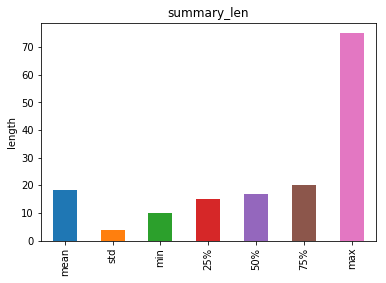

In [25]:
print('summary_len > 40 :',len(p_train_df[p_train_df['summary_len']>30]))  # max_dec_steps
print('summary_len <= 10 :',len(p_train_df[p_train_df['summary_len']<=10])) # min_dec_steps

s = p_train_df['summary_len'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('length')
plt.title('summary_len')
plt.show()

# Prune data length

In [32]:
print('reveiw_len <= 800 and summary_len<= 30:',len(p_train_df[
    (p_train_df['reveiw_len']<=800) & (p_train_df['summary_len']<=30)                                        
                                        ]))

reveiw_len <= 800 and summary_len<= 30: 494171


# percent_lcs EDA(20 divided)

count    504075.000000
mean         40.193632
std          13.125338
min           3.333333
25%          29.411765
50%          40.000000
75%          50.000000
max          82.758621
Name: percent_lcs, dtype: float64


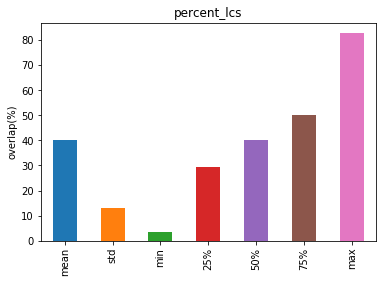

percent_lcs x < 20 :5.02 %
percent_lcs 20 < x < 40 :40.56 %
percent_lcs 40 < x < 60 :42.63 %
percent_lcs 60 < x < 80 :5.69 %
percent_lcs x > 80  :0.00 %


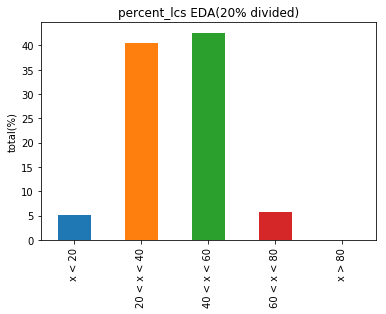

In [11]:
# 统计学上的四分为函数
# 原则上p是可以取0到1之间的任意值的。但是有一个四分位数是p分位数中较为有名的。

# 所谓四分位数；即把数值由小到大排列并分成四等份，处于三个分割点位置的数值就是四分位数。

# 第1四分位数 (Q1)，又称“较小四分位数”，等于该样本中所有数值由小到大排列后第25%的数字。
# 第2四分位数 (Q2)，又称“中位数”，等于该样本中所有数值由小到大排列后第50%的数字。
# 第3四分位数 (Q3)，又称“较大四分位数”，等于该样本中所有数值由小到大排列后第75%的数字。
# 第3四分位数与第1四分位数的差距又称四分位距（InterQuartile Range,IQR）

s = p_train_df['percent_lcs'].describe(); print(s)
s = s.drop(labels = ['count'])
s.plot.bar()
plt.ylabel('overlap(%)')
plt.title('percent_lcs')
plt.show()

print('percent_lcs x < 20 :%.2f' % float(len(p_train_df[p_train_df['percent_lcs']<20])/len(p_train_df)*100),'%' )  # overlap percent with summary
print('percent_lcs 20 < x < 40 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>20) & (p_train_df['percent_lcs']<40)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs 40 < x < 60 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>40) & (p_train_df['percent_lcs']<60)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs 60 < x < 80 :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>60) & (p_train_df['percent_lcs']<80)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs x > 80  :%.2f' % float( \
      len(p_train_df[(p_train_df['percent_lcs']>80)])/len(p_train_df)*100),'%')  # max_dec_steps


s = pd.Series({'x < 20':len(p_train_df[p_train_df['percent_lcs']<20])/len(p_train_df)*100, 
           '20 < x < 40':len(p_train_df[(p_train_df['percent_lcs']>20) & (p_train_df['percent_lcs']<40)])/len(p_train_df)*100, 
           '40 < x < 60':len(p_train_df[(p_train_df['percent_lcs']>40) & (p_train_df['percent_lcs']<60)])/len(p_train_df)*100, 
           '60 < x < 80':len(p_train_df[(p_train_df['percent_lcs']>60) & (p_train_df['percent_lcs']<80)])/len(p_train_df)*100, 
           'x > 80':len(p_train_df[p_train_df['percent_lcs']>80])/len(p_train_df)*100          
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs EDA(20% divided)')
plt.show()

In [12]:
'''
overlap => lcs > (20% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

# print('overlap Top : %2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 0])/len(p_train_df)*100),'%') 
# print('overlap Final :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 1])/len(p_train_df)*100),'%') 
# print('overlap Other Pos :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == 2])/len(p_train_df)*100),'%')
# print('No overlap :%2.2f'% float(len(p_train_df[p_train_df['overlap_pos'] == -1])/len(p_train_df)*100),'%') 

# s = pd.Series({'overlap Top':len(p_train_df[p_train_df['overlap_pos'] == 0])/len(p_train_df)*100, 
#            'overlap Final':len(p_train_df[p_train_df['overlap_pos'] == 1])/len(p_train_df)*100, 
#            'overlap Other Pos':len(p_train_df[p_train_df['overlap_pos'] == 2])/len(p_train_df)*100, 
#            'No overlap':len(p_train_df[p_train_df['overlap_pos'] == -1])/len(p_train_df)*100, 
#           })
# print(s)
# s.plot.bar()
# plt.ylabel('overlap(%)')
# plt.title('percent_lcs')
# plt.show()

'\noverlap => lcs > (20% summary len)\noverlap_pos : 0 Top\noverlap_pos : 1 Final\noverlap_pos : 2 Other Pos\noverlap_pos : -1 No overlap\n'

# Ext/Abs分界(50)

percent_lcs x > 50  22.61 %
percent_lcs x <= 50  77.39 %


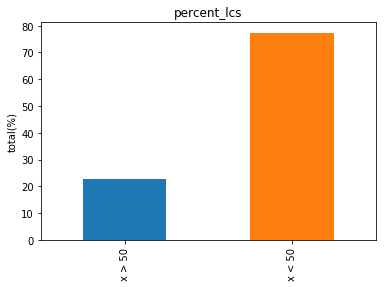

In [13]:
print('percent_lcs x > 50  %2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%')  # max_dec_steps
print('percent_lcs x <= 50  %2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100),'%')  # max_dec_steps

s = pd.Series({'x > 50':len(p_train_df[(p_train_df['percent_lcs']>50)])/len(p_train_df)*100, 
           'x < 50':len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100,      
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('percent_lcs')
plt.show()

overlap Top :7.47 %
overlap Final :0.00 %
overlap Other Pos :15.14 %
No overlap :77.39 %


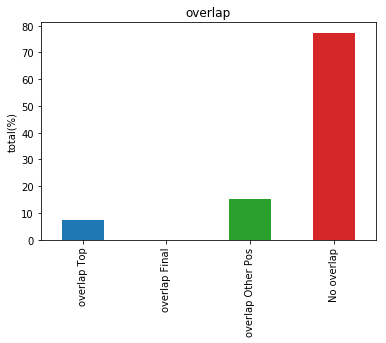

In [14]:
'''
overlap => lcs > (20% summary len)
overlap_pos : 0 Top
overlap_pos : 1 Final
overlap_pos : 2 Other Pos
overlap_pos : -1 No overlap
'''

print('overlap Top :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 0) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('overlap Final :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 1) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('overlap Other Pos :%2.2f'% float(len(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100),'%') 
print('No overlap :%2.2f'% float(len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100),'%') 

s = pd.Series({'overlap Top':len(p_train_df[(p_train_df['overlap_pos'] == 0) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100, 
           'overlap Final':len(p_train_df[(p_train_df['overlap_pos'] == 1) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100,      
           'overlap Other Pos':len(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)])/len(p_train_df)*100,  
           'No overlap':len(p_train_df[(p_train_df['percent_lcs']<=50)])/len(p_train_df)*100,  
          })
s.plot.bar()
plt.ylabel('total(%)')
plt.title('overlap')
plt.show()

In [15]:
def view(df, condition, view_num=10):
    package_dict = []
    for i in range(view_num):
        d1 = dict(p_train_df[eval(condition)].iloc[i])
        d2 = {'review':d1['review'],
              'summary':d1['summary'],
              'token_lcs':d1['token_lcs'],
              'overlap':d1['overlap'],
              'percent_lcs':d1['percent_lcs'],
             }
        package_dict.append(d2)
    return package_dict
        
# view(p_train_df, "(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)")
view(p_train_df, "(p_train_df['summary_len']<11)")

[{'review': 'use workstation raid0 configuration datum drive . these drive are very quiet and not produce too much heat . they are reasonably fast and have enough cache for workstation datum task . they are sas enterprise quality sata price . they were deliver time . package with hard drive critical . they were package someone who know what they were do with good quality packing material . conclusion very fast raid0 capacity more than adequate overall performance very good price right sas simultaneous read write enterprise quality not like .',
  'summary': '<s> performance capacity price </s>',
  'token_lcs': 'price price ',
  'overlap': nan,
  'percent_lcs': 20.0},
 {'review': 'class href arp rvw txt utf8 continental tour ride urban bicycle tire these tire are great for all around use . have these fully ridge giant atx use all terrain tour bike . ride paved road and trail gravel crush limestone and even mild single track . they handle all very well even wet pavement . the only thing t

In [16]:
dict(p_train_df[(p_train_df['overlap_pos'] == 2) & (p_train_df['percent_lcs']>50)].iloc[0:10])['summary']

21372                 <s> not the lens thought was buy </s>
83984              <s> work on ath with vmoda boom pro </s>
145586    <s> compact soundbar that enhance dialogue and...
15708     <s> it is great telephoto converter lens very ...
530551    <s> this sweater work even better than the con...
526501    <s> see the same costume on slender mixed bree...
307328    <s> this is an all around winner if you are lo...
397590    <s> the star had been bump up from two to four...
548368    <s> both my dog and absolutely love this lead ...
439326    <s> unfortunately the ink that come with the p...
Name: summary, dtype: object

['cat', '##.', '##.', '##.', '##dog']